# Bài toán

Bài toán này sử dụng bộ dữ liệu về các chuyến đi taxi ở New York để so sánh hiệu suất của ba mô hình tăng cường khác nhau: `GradientBoostingRegressor` từ scikit-learn, `XGBRegressor` từ XGBoost và `LGBMRegressor` từ LightGBM. Mục tiêu là dự đoán thời gian chuyến đi dựa trên các đặc trưng như vị trí đón và trả khách, số lượng hành khách, v.v. Bạn có thể xem bộ dữ liệu gốc ở đây: [NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data).

Bộ dữ liệu gồm 1458644 chuyến đi taxi với các cột chính như:
- id: Mã định danh chuyến đi
- vendor_id: Mã định danh nhà cung cấp dịch vụ taxi
- pickup_datetime: Thời gian đón khách
- dropoff_datetime: Thời gian trả khách
- passenger_count: Số lượng hành khách
- pickup_longitude, pickup_latitude: Vĩ độ và kinh độ điểm đón khách
- dropoff_longitude, dropoff_latitude: Vĩ độ và kinh độ điểm trả khách
- store_and_fwd_flag: Tài xế taxi đó có được kết nối mạng không
- trip_duration: Thời gian chuyến đi (mục tiêu cần dự đoán)

> **Lưu ý:** Để chạy mã này, bạn cần cài đặt các thư viện `pandas`, `numpy`, `scikit-learn`, `xgboost`, và `lightgbm`. Bạn có thể cài đặt chúng qua pip nếu chưa có:
> ```bash
> pip install pandas numpy scikit-learn xgboost lightgbm shap
> ```

> **Giả thuyết:** Vì bộ dữ liêu này có kích thước lớn, ta mong đợi rằng thời gian chạy của LightGBM sẽ nhanh nhất, tiếp theo là XGBoost, và cuối cùng là GradientBoostingRegressor từ scikit-learn. Về độ chính xác, ta kỳ vọng rằng cả ba mô hình sẽ xếp hạng lần lượt là GradientBoostingRegressor, XGBoost, và LightGBM nhưng không đáng kể.

# Import Library

In [ ]:
import pandas as pd
import numpy as np 
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import threading
import time as time_module

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import MiniBatchKMeans

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
import os

train_path = './taxi_trip.csv'

train = pd.read_csv(train_path)
print(f"Loaded {len(train):,} rows of data")

print(f"\nFirst 5 rows:")
print(train.head())

print(f"\nBasic statistics:")
print(train.describe())

Loaded 1,458,644 rows of data

First 5 rows:
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602        

# Remove Outliner

In [3]:
train_clean = train.copy()
print(f"Original data: {len(train_clean):,} rows")

columns_to_remove = []

if 'dropoff_datetime' in train_clean.columns:
    # Removing dropoff_datetime as it is make prediction trivial
    columns_to_remove.append('dropoff_datetime')
    
if 'store_and_fwd_flag' in train_clean.columns:
    # Removing store_and_fwd_flag as it not useful for prediction
    columns_to_remove.append('store_and_fwd_flag')

if columns_to_remove:
    train_clean = train_clean.drop(columns=columns_to_remove)
    print(f"Removed columns: {columns_to_remove}")

print("Cleaning trip_duration...")
before_clean = len(train_clean)

# Remove non-positive trip durations and extreme outliers
train_clean = train_clean[
    (train_clean['trip_duration'] >= 60) & 
    (train_clean['trip_duration'] <= 10800)
]

Original data: 1,458,644 rows
Removed columns: ['dropoff_datetime', 'store_and_fwd_flag']
Cleaning trip_duration...


# Make Pickup Destination and Dropoff Destination is in the same city

In [4]:
print("Cleaning geographic coordinates...")

before_coord_clean = len(train_clean)

# NYC approximate bounding box
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train_clean = train_clean[
    (train_clean['pickup_longitude'] >= city_long_border[0]) &
    (train_clean['pickup_longitude'] <= city_long_border[1]) &
    (train_clean['pickup_latitude'] >= city_lat_border[0]) &
    (train_clean['pickup_latitude'] <= city_lat_border[1]) &
    (train_clean['dropoff_longitude'] >= city_long_border[0]) &
    (train_clean['dropoff_longitude'] <= city_long_border[1]) &
    (train_clean['dropoff_latitude'] >= city_lat_border[0]) &
    (train_clean['dropoff_latitude'] <= city_lat_border[1])
]

train_clean = train_clean.reset_index(drop=True)

Cleaning geographic coordinates...


# Convert pickup_datetime to datetime object

In [5]:
# Convert pickup_datetime to datetime object
train_clean['pickup_datetime'] = pd.to_datetime(train_clean['pickup_datetime'])

train_clean['hour'] = train_clean['pickup_datetime'].dt.hour
train_clean['day_of_week'] = train_clean['pickup_datetime'].dt.dayofweek
train_clean['month'] = train_clean['pickup_datetime'].dt.month
train_clean['day_of_month'] = train_clean['pickup_datetime'].dt.day

# Adding Features For Better Prediction

In [6]:
print("Calculating distances and adding features...")

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate haversine distance between two points"""
    R = 6371
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    
    return distance

def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calculate Manhattan distance"""
    a = haversine_distance(lat1, lon1, lat1, lon2)
    b = haversine_distance(lat1, lon1, lat2, lon1)
    return a + b

tqdm.pandas(desc="Calculating Haversine distance")
train_clean['distance_haversine'] = train_clean.progress_apply(
    lambda row: haversine_distance(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    ), axis=1
)

tqdm.pandas(desc="Calculating Manhattan distance")
train_clean['distance_manhattan'] = train_clean.progress_apply(
    lambda row: manhattan_distance(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    ), axis=1
)


Calculating distances and adding features...


Calculating Haversine distance:   0%|          | 0/1429074 [00:00<?, ?it/s]

Calculating Manhattan distance:   0%|          | 0/1429074 [00:00<?, ?it/s]

# Clustering Location Data using KMeans for Another Feature

In [7]:
print("Creating location clusters...")

coords = np.vstack((
    train_clean[['pickup_latitude', 'pickup_longitude']].values,
    train_clean[['dropoff_latitude', 'dropoff_longitude']].values
))

sample_size = min(100000, len(coords))
sample_ind = np.random.permutation(len(coords))[:sample_size]

print(f"Performing clustering with {sample_size:,} points...")
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=5000, random_state=42)
kmeans.fit(coords[sample_ind])

train_clean['pickup_cluster'] = kmeans.predict(train_clean[['pickup_latitude', 'pickup_longitude']])
train_clean['dropoff_cluster'] = kmeans.predict(train_clean[['dropoff_latitude', 'dropoff_longitude']])

Creating location clusters...
Performing clustering with 100,000 points...


# Feature Engineering to Scale the Data

In [8]:
print("Applying log transformation to trip_duration...")

# Add 1 to avoid log(0)
train_clean['log_trip_duration'] = np.log(train_clean['trip_duration'] + 1)

Applying log transformation to trip_duration...


# Prepare Data for Modeling

In [9]:
feature_columns = [
    'vendor_id', 'passenger_count',
    'pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude',
    'hour', 'day_of_week', 'month', 'day_of_month',
    'distance_haversine', 'distance_manhattan',
    'pickup_cluster', 'dropoff_cluster'
]

available_features = [col for col in feature_columns if col in train_clean.columns]
missing_features = [col for col in feature_columns if col not in train_clean.columns]

X = train_clean[available_features].copy()
y = train_clean['log_trip_duration'].copy()

if X.isnull().sum().sum() > 0:
    print(f"Detected {X.isnull().sum().sum()} missing values")
    print("Handling missing values...")
    X = X.fillna(X.median())

print(f"\nSplitting data into train/test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")


Splitting data into train/test...
Training data: (1143259, 14), Test data: (285815, 14)


# Train model GradientBoostingRegressor

In [10]:
gb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'random_state': 42
}

results = {}

start_time = time.time()

print("Training Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(**gb_params)
gb_model.fit(X_train, y_train)

gb_time = time.time() - start_time

print(f"\nEvaluating Gradient Boosting Model...")
y_pred_gb = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"Gradient Boosting training time: {gb_time:.2f} seconds")
print(f"Gradient Boosting RMSE: {gb_rmse:.4f}")
print(f"Number of trees trained: {gb_model.n_estimators}")

results['GradientBoosting'] = {
    'model': gb_model,
    'time': gb_time,
    'rmse': gb_rmse,
    'predictions': y_pred_gb
}

print(f"Gradient Boosting training completed!")

Training Gradient Boosting Model...



Evaluating Gradient Boosting Model...
Gradient Boosting training time: 504.61 seconds
Gradient Boosting RMSE: 0.3457
Number of trees trained: 100
Gradient Boosting training completed!


# Train model XGBoostRegressor

In [11]:
print("Preparing DMatrix for XGBoost...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'silent': 1,
    'random_state': 42
}

num_rounds = 100
start_time = time.time()

print("Training XGBoost Model...")
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    verbose_eval=False
)

xgb_time = time.time() - start_time

print(f"\nEvaluating XGBoost Model...")
y_pred_xgb = xgb_model.predict(dtest)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost training time: {xgb_time:.2f} seconds")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

results['XGBoost'] = {
    'model': xgb_model,
    'time': xgb_time,
    'rmse': xgb_rmse,
    'predictions': y_pred_xgb
}

print(f"XGBoost training completed!")

Preparing DMatrix for XGBoost...
Training XGBoost Model...

Evaluating XGBoost Model...
XGBoost training time: 2.98 seconds
XGBoost RMSE: 0.3483
XGBoost training completed!


# Train model LGBMRegressor

In [12]:
print("Preparing dataset for LightGBM...")
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'max_depth': 6,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'verbosity': -1,
    'random_state': 42
}

start_time = time.time()

num_rounds = 100

print("Training LightGBM Model...")
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=num_rounds,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'eval'],
)

lgb_time = time.time() - start_time

print(f"\nEvaluating LightGBM Model...")
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM training time: {lgb_time:.2f} seconds")
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"Best iteration: {lgb_model.best_iteration}")

results['LightGBM'] = {
    'model': lgb_model,
    'time': lgb_time,
    'rmse': lgb_rmse,
    'predictions': y_pred_lgb
}

print(f"LightGBM training completed!")

Preparing dataset for LightGBM...
Training LightGBM Model...

Evaluating LightGBM Model...
LightGBM training time: 3.67 seconds
LightGBM RMSE: 0.3473
Best iteration: 0
LightGBM training completed!


# Results Comparison

In [13]:
print("MODEL COMPARISON RESULTS")
print("=" * 60)

comparison_data = []
for model_name, data in results.items():
    comparison_data.append({
        'Model': model_name,
        'Training Time (s)': f"{data['time']:.2f}",
        'RMSE': f"{data['rmse']:.4f}",
        'Relative Speed': f"{min([r['time'] for r in results.values()]) / data['time']:.2f}x"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nRANKING TABLE:")
print(comparison_df.to_string(index=False))

best_model_rmse = min(results.keys(), key=lambda x: results[x]['rmse'])
fastest_model = min(results.keys(), key=lambda x: results[x]['time'])

print(f"\nBest model (RMSE): {best_model_rmse} ({results[best_model_rmse]['rmse']:.4f})")
print(f"Fastest model: {fastest_model} ({results[fastest_model]['time']:.2f}s)")

rmse_values = [results[model]['rmse'] for model in results.keys()]
time_values = [results[model]['time'] for model in results.keys()]

print(f"\nDETAILED ANALYSIS:")
print(f"   - RMSE difference: {max(rmse_values) - min(rmse_values):.4f}")
print(f"   - Time ratio: {max(time_values) / min(time_values):.1f}x")

print(f"\nPERFORMANCE vs SPEED ANALYSIS:")
for model_name, data in results.items():
    speed_rank = sorted(results.keys(), key=lambda x: results[x]['time']).index(model_name) + 1
    acc_rank = sorted(results.keys(), key=lambda x: results[x]['rmse']).index(model_name) + 1
    print(f"   {model_name:15} - Speed Rank: #{speed_rank}, Accuracy Rank: #{acc_rank}")

print(f"\nModel comparison completed!")

MODEL COMPARISON RESULTS

RANKING TABLE:
           Model Training Time (s)   RMSE Relative Speed
GradientBoosting            504.61 0.3457          0.01x
         XGBoost              2.98 0.3483          1.00x
        LightGBM              3.67 0.3473          0.81x

Best model (RMSE): GradientBoosting (0.3457)
Fastest model: XGBoost (2.98s)

DETAILED ANALYSIS:
   - RMSE difference: 0.0025
   - Time ratio: 169.1x

PERFORMANCE vs SPEED ANALYSIS:
   GradientBoosting - Speed Rank: #3, Accuracy Rank: #1
   XGBoost         - Speed Rank: #1, Accuracy Rank: #3
   LightGBM        - Speed Rank: #2, Accuracy Rank: #2

Model comparison completed!


# Interpret with SHAP

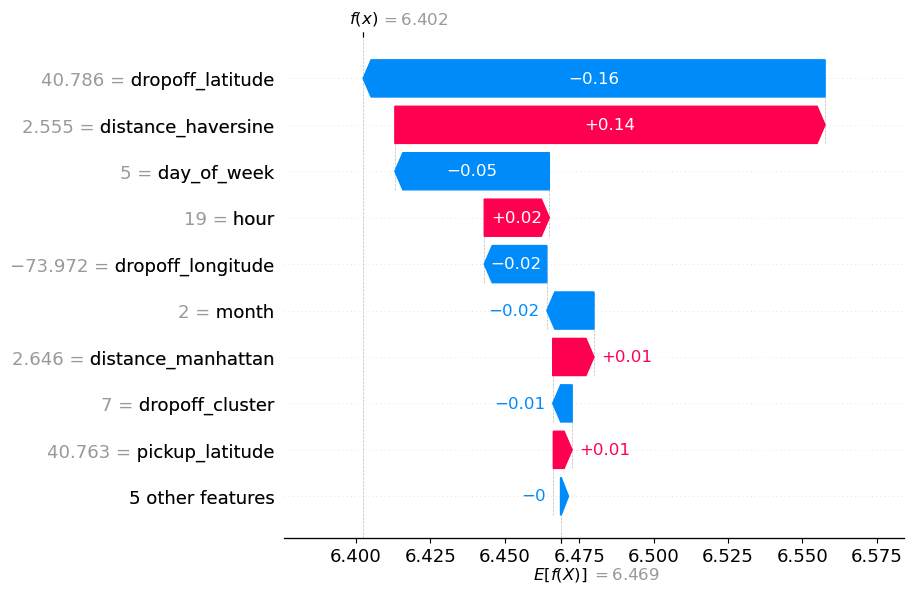

In [15]:
import shap
import matplotlib.pyplot as plt

# Set plotting style for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

explainer = shap.Explainer(xgb_model, feature_names=available_features)
shap_values = explainer(dtest)
shap.plots.waterfall(shap_values[0])

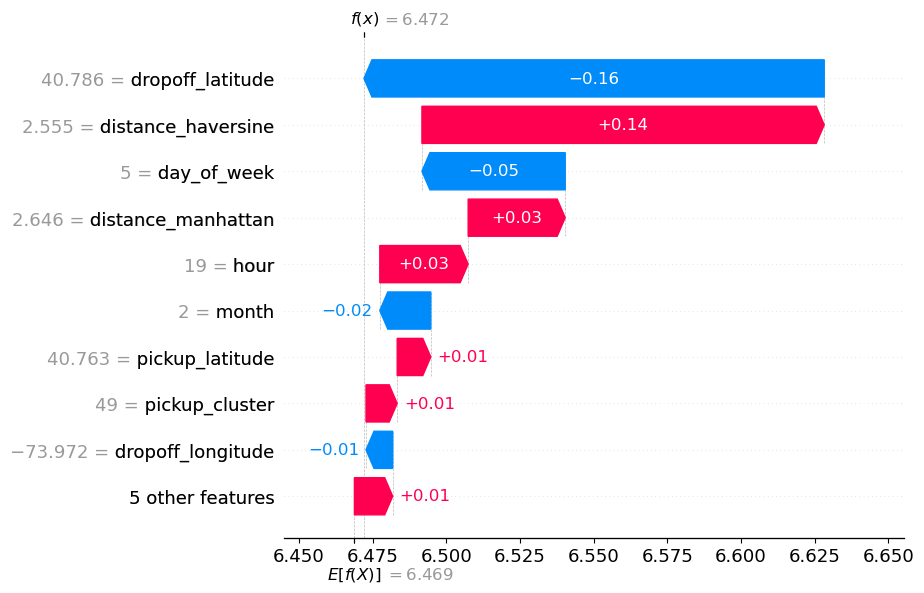

In [ ]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])